# Coin Classifier

In [168]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [169]:
data_dir = '/home/pablo/Desktop/stuff/coin_cnn/data'

train_dir = data_dir + '/train'
valid_dir = data_dir + '/validation'

In [170]:
train_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.RandomRotation(25),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor()])

valid_transforms = transforms.Compose([transforms.Resize(260),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=20, shuffle=True)

In [171]:
dataloaders = {'train_loader': train_loader, 'valid_loader': valid_loader}

### Visualize the data

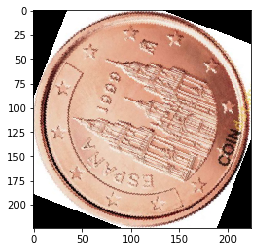

In [172]:
images, labels = next(iter(dataloaders['train_loader']))
image = images[0].permute(2, 1, 0).numpy()
imgplot = plt.imshow(image)
plt.show()

### Label Mapping

In [173]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
# Make sure it is loaded right
cat_to_name["23"]

'5 Cents,Canadian Dollar,canada'

### Load the models

In [174]:
# Pre-trained  resnet152
model_resnet152 = models.resnet152(pretrained=True)

# Freeze parameters in pre trained ResNET
for param in model_resnet152.parameters():
    param.requires_grad = False

out_classes = len(cat_to_name)

model_resnet152.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, out_classes)
)

# Check the modified fc layer
print(model_resnet152.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=1024, out_features=211, bias=True)
)


### Check for GPU

In [175]:
is_GPU_available = torch.cuda.is_available()

if is_GPU_available:
    device = 'cuda'
    print('training on GPU')
else:
    device = 'cpu'
    print('training on CPU')
    
my_model = model_resnet152

my_model.to(device)

training on GPU


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

### Save and Load the checkpoint

In [176]:
def save_model(model, val_loss):
    model = {
        'name': 'resnet152',
        'state_dict': model.state_dict(),
        'fc': model.fc,
        'min_val_loss': val_loss
    }
    
    torch.save(model, 'checkpoint_cnn_resnet152.pth')

In [177]:
def load_checkpoint_resnet152(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152(pretrained=True)
    model.fc = checkpoint['fc']
    model.load_state_dict(checkpoint['state_dict'])
    
    # Freeze parameters (in case we want to train more)
    for param in model.parameters():
        param.requires_grad = False
        
    return model

### Train the network

In [178]:
def train (my_model, epochs = 25, min_valid_loss=np.Inf, lr=0.001):
    None